1. 결측치
    - 평균 +/- 분산 -> 범위안에서 랜덤으로 선택
    - 0 또는 지정된 숫자로 nan값을 채울 수가 있음 -> -999로 채우는 예시
        - e.g.) 전체 컬럼의 값이 0, 1, nan 중 하나 입니다(이진). nan = -999로 채우면... 0, 1, -999가 연속변수(모델이 잘못인식 할 수 있음)라고 착각할 수 있음 -> 클래스 형태로 feature를 변환하자! (정답은 아님)
            - e.g.) encoding:0 -> 1 0 0, 1-> 0 1 0 ... (하나의 클래스로 인식시키는 방법으로)
    - 해당 컬럼의 이전값 또는 이후값으로 nan값을 채울 수 있음
    - EDA를 통해서도 컬럼값을 채울 수 있음
    - 마스킹 데이터 전처리 과정에서 지워도 됨! 

2. feature 수(축소)
    - 모든 feature 선택해도 무방하지만
        - 리소스 부족 : 컴퓨터 사양 문제
    - 왜 feature 수를 줄여야하는가! -> 다중공선성 문제... 등등 -> feature 줄여!
    - vif, correlation(pearson) : 1차적으로 줄일 수 있음
    - 모든 feature를 사용하여 차원을 축소하는 방법
        - random forest: feature_importances_ -> 각 feature마다 점수가 나온다! 상위 20개 100개
        - svm : coef_
        - 👍🏻[모델이 학습하면서 feature 선택](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html)

3. Modeling
    - 결측치 처리 후, XGBoost, logistic regression
    
    
    
[AMEX-Data Preprocesing & Feature Engineering](https://www.kaggle.com/code/susnato/amex-data-preprocesing-feature-engineering)

# IEEE-CIS Fraud Detection Modeling 


<font size="5">[kaggle](https://www.kaggle.com/competitions/ieee-fraud-detection/overview/description)</font>


## 개요(Overview)

[Description](https://www.kaggle.com/competitions/ieee-fraud-detection/overview/description)

**실제 상거래 데이터에서 이상거래를 탐지** <br>
이상 거래라고 하면 일반적인 **binary classification 문제**와 가장 크게 다른 점이라고 한다면 **타겟 불균형**이 되겠습니다. 그래서 보통 over/under sampling 기법을 활용하기도 하고 요즘엔 **unsupervised learning을 활용**한 방법도 많이 나와있습니다.


**Evaluation**
- ROC curve
- TransactionID(PK) 
- isFraud (**Target, 사기 거래일 확률 예측**)

[Link](https://www.kaggle.com/code/datasoin/eda-team-o/notebook?scriptVersionId=74651045)!! -> 참고함

[참고자료]
1. [EDA and models](https://www.kaggle.com/code/artgor/eda-and-models) # 인강 내용  <br>
2. [Extensive EDA and Modeling XGB Hyperopt](https://www.kaggle.com/code/kabure/extensive-eda-and-modeling-xgb-hyperopt)
3. [blog](https://slowsteadystat.tistory.com/19)
    1. [Winning solutions listed](https://www.kaggle.com/c/ieee-fraud-detection/discussion/111252)
    2. [1st Place Solution](https://www.kaggle.com/c/ieee-fraud-detection/discussion/111308) <br>
        1. [Short Summary](https://www.kaggle.com/c/ieee-fraud-detection/discussion/111257#latest-641140) <br>
        2. EDA
         - NaN과 상관있는 변수 탐색, 변수 간 corr(이 후 feature selection에 활용
        3. Feature Selection
         - forward feature selection (using single or groups of features)
         - recursive feature elimination (using single or groups of features)
         - permutation importance
         - adversarial validation
         - correlation analysis
         - time consistency
         - client consistency
         - train/test distribution analysis

 <font size="5">[goeun] TransactionAmt, card, emaildomain, **V**</font> <br>
``row 건드리지 말 것!``<br>
 EDA & DATA Preprocessing
 


## 필요한 라이브러리와 데이터를 불러오기

In [1]:
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np   # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMRegressor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

In [2]:
base_path = '/Users/goeun/Documents/YearDream/MiniProJect/6월_ML/ieee-fraud-detection(git)/mini_pjt_modeling/project/data/raw/'

train = pd.read_csv(base_path + 'train.csv')
test = pd.read_csv(base_path + 'test.csv')
submission = pd.read_csv(base_path + 'sample_submission.csv')

In [47]:
total = pd.concat([train, test])
# total

In [3]:
# shape 확인
train.shape, test.shape, submission.shape

((590540, 434), (506691, 433), (506691, 2))

In [4]:
# total cells
np.product(train.shape),np.product(test.shape), np.product(submission.shape)

(256294360, 219397203, 1013382)

## EDA

<font size="4">fraud detection data describe</font>

주 데이터는 identity 와 transaction으로 나뉘며, TransactionID을 공통분모를 가짐

**1. train_transaction Table : 거래 관련**<br>

| Column Name | Description | Dtype |
| ----------- | ----------- |-----|
| TransactionID|고유값, PK|int64 |
|isFraud|사기 거래 수(``traget``)|int64(binary)|
|TransactionDT|주어진 참조 datetime의 timedelta(실제 타임스탬프가 아님), 초단위|int64|
| TransactionAMT|거래 결제 금액(USD)|float64 |
| ProductCD| 제품 코드, 각 거래에 대한 제품|object|
| card1 - card6| 카드 종류, 카드 종류, 발행 은행, 국가 등의 결제 카드 정보|``int64`` or ``float64`` or ``object``|
| addr|주소|float64|
| dist|거리|float64|
| P_ and (R__) emaildomain| 구매자 및 수신자 이메일 도메인|object|
| C1-C14|지불 카드와 연결된 것으로 확인된 주소 수 등의 계산. 실제 의미는 가려져 있습니다.|float64|
| D1-D15|이전 트랜잭션 사이의 날짜 등과 같은 timedelta|float64|
| M1-M9|카드의 이름 및 주소 등과 같은 일치|object|
| Vxxx|Vesta는 순위, 계산 및 기타 엔터티 관계를 포함하여 풍부한 기능을 엔지니어링했습니다.|float64|

> **Categorical Features**  <br>
ProductCD <br>
card1 - card6 <br>
addr1, addr2 <br>
P_emaildomain <br>
R_emaildomain <br>
M1 - M9

### train 데이터 확인

In [5]:
# print(train.info(verbose=True, null_counts=True))

display(train.head(2))
display(train.tail(2))

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590539,3577539,0,15811131,279.95,W,15066,170.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return
resumetable(train)[3:17]
# TransactionAmt, card, emaildomain, V

Dataset Shape: (590540, 434)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
3,TransactionAmt,float64,0,20902,68.5,29.0,59.0,8.35
4,ProductCD,object,0,5,W,W,W,1.28
5,card1,int64,0,13553,13926,2755,4663,9.97
6,card2,float64,8933,500,NaN,404.0,490.0,6.32
7,card3,float64,1565,114,150.0,150.0,150.0,0.68
8,card4,object,1577,4,discover,mastercard,visa,1.09
9,card5,float64,4259,119,142.0,102.0,166.0,2.66
10,card6,object,1571,4,credit,credit,debit,0.82
11,addr1,float64,65706,332,315.0,325.0,330.0,5.06
12,addr2,float64,65706,74,87.0,87.0,87.0,0.08


#### isFraud(traget)

In [7]:
train.isFraud.isna().sum()

0

0    569877
1     20663
Name: isFraud, dtype: int64


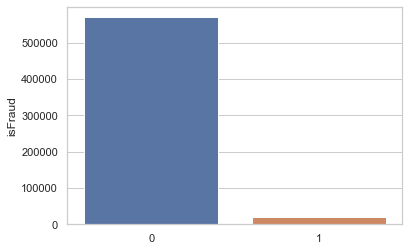

In [8]:
print(train.isFraud.value_counts())

sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x = train.isFraud.value_counts().index, y = train.isFraud.value_counts(), data=train)

traget의 편차가 큼(타켓 불균형)

In [39]:
# 샘플데이터 500 Fraud adn 500 Non Fraud sampled_train 저장
sampled_train = pd.concat([train.loc[train['isFraud'] == 0 ].sample(500),
                         train.loc[train['isFraud'] == 1].sample(500)])
# sampled_train

<font size="5">DataFrame describe</font> <br>
``train(raw)`` = train_id.csv + train_transaction.csv<br>
``train_goeun`` = TransactionID + isFraud + TransactionAmt + (card1~card6) + (P_and(R_)emaildomain)<br>
``train_v`` = TransactionID + isFraud + TransactionAmt + Vxxx

### 필요한 데이터만 변수 생성('train_goeun') & Vxxx column  변수 생성('train_v') 및 확인

#### train_goeun

In [42]:
# TransactionAmt, card, emaildomain
train_goeun = train[['TransactionID','isFraud','TransactionAmt','card1', 'card2','card3','card4','card5','card6','P_emaildomain','R_emaildomain']]
train_goeun.head()

,TransactionID,isFraud,TransactionAmt,card1,card2,card3,card4,card5,card6,P_emaildomain,R_emaildomain
0,2987000,0,68.5,13926,NaN,150.0,discover,142.0,credit,NaN,NaN
1,2987001,0,29.0,2755,404.0,150.0,mastercard,102.0,credit,gmail.com,NaN
2,2987002,0,59.0,4663,490.0,150.0,visa,166.0,debit,outlook.com,NaN
3,2987003,0,50.0,18132,567.0,150.0,mastercard,117.0,debit,yahoo.com,NaN
4,2987004,0,50.0,4497,514.0,150.0,mastercard,102.0,credit,gmail.com,NaN


In [13]:
train_goeun.describe()

,TransactionID,isFraud,TransactionAmt,card1,card2,card3,card5
count,5.905400e+05,590540.000000,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000
mean,3.282270e+06,0.034990,135.027176,9898.734658,362.555488,153.194925,199.278897
std,1.704744e+05,0.183755,239.162522,4901.170153,157.793246,11.336444,41.244453
min,2.987000e+06,0.000000,0.251000,1000.000000,100.000000,100.000000,100.000000
25%,3.134635e+06,0.000000,43.321000,6019.000000,214.000000,150.000000,166.000000
50%,3.282270e+06,0.000000,68.769000,9678.000000,361.000000,150.000000,226.000000
75%,3.429904e+06,0.000000,125.000000,14184.000000,512.000000,150.000000,226.000000
max,3.577539e+06,1.000000,31937.391000,18396.000000,600.000000,231.000000,237.000000


#### train_goeun 결측치 확인

In [40]:
train_goeun.isna().sum()

TransactionID          0
isFraud                0
TransactionAmt         0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
P_emaildomain      94456
R_emaildomain     453249
dtype: int64

In [44]:
# 결측 비율
(train_goeun.isna().sum()/len(train))*100

TransactionID      0.000000
isFraud            0.000000
TransactionAmt     0.000000
card1              0.000000
card2              1.512683
card3              0.265012
card4              0.267044
card5              0.721204
card6              0.266028
P_emaildomain     15.994852
R_emaildomain     76.751617
dtype: float64

> **설명**<br>
card2~card6 column과 P_(or R)emaildomain column 데이터를 확인하고 결측치 처리

In [45]:
train_goeun_missing = train_goeun.isna().sum()
print("% of total missing data = ",(train_goeun_missing.sum()/np.product(train_goeun.shape))*100)

% of total missing data =  8.707130915618063


#### train_v

In [14]:
# train_v = Vxxx 
v_cols = [v for v in train if v[0] == 'V']
v = train[v_cols]
merge = train.iloc[:,:4]
train_v = pd.concat([merge, v], axis = 1, join='inner')
train_v.drop(columns='TransactionDT', inplace=True)

In [15]:
train_v

,TransactionID,isFraud,TransactionAmt,V1,V2,V3,V4,V5,V6,V7,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,68.50,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,29.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,59.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,50.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,50.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,49.00,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,39.50,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,30.95,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,117.00,1.0,1.0,1.0,2.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
train_v.describe()

,TransactionID,isFraud,TransactionAmt,V1,V2,V3,V4,V5,V6,V7,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.905400e+05,590540.000000,590540.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
mean,3.282270e+06,0.034990,135.027176,0.999945,1.045204,1.078075,0.846456,0.876991,1.045686,1.072870,...,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,1.704744e+05,0.183755,239.162522,0.007390,0.240133,0.320890,0.440053,0.475902,0.239385,0.304779,...,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,2.987000e+06,0.000000,0.251000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,3.134635e+06,0.000000,43.321000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,3.282270e+06,0.000000,68.769000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,3.429904e+06,0.000000,125.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,25.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,3.577539e+06,1.000000,31937.391000,1.000000,8.000000,9.000000,6.000000,6.000000,9.000000,9.000000,...,55.000000,160000.000000,160000.000000,160000.000000,55125.000000,55125.00000,55125.000000,104060.000000,104060.000000,104060.000000


<AxesSubplot:>

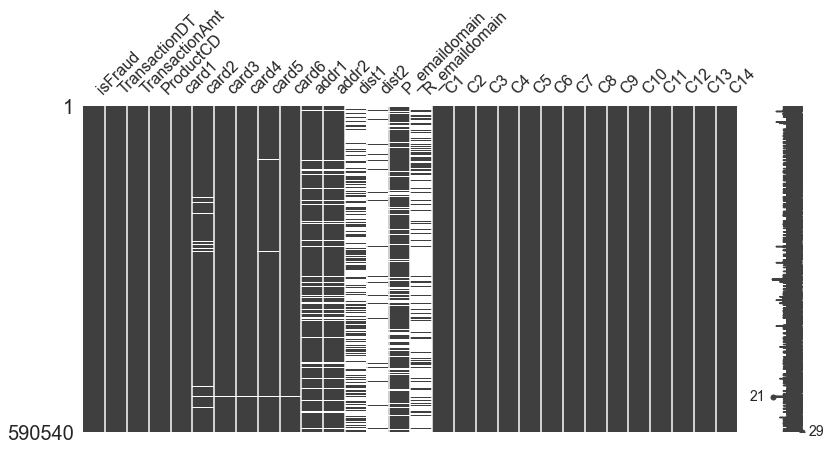

In [17]:
# 훈련 데이터 결측값 시각화 1
msno.matrix(df = train.iloc[:,1:31], figsize=(13,6))

오른쪽 막대는 결측값의 상대적인 분포, 뾰족하게 튀어나온 부분이 결측값이 몰려있는 행 의미, 왼쪽에 표시된 21는 결측값이 없는 열의 개수, 오른쪽의 29는 전체 열의 개수를 나타냄

위 표에서 볼 수 있듯이 사기 거래인 데이터는 전체의 약 3.5%에 못 미치며 데이터 불균형을 초래하고 있다. <br>
또한 데이터에 대한 이슈는 아래에서 계속 찾아볼 수 있는데, Train data와 Test data 사이 시간적 공백이 존재한다는 것이다.¶

#### TransactionAmt

Mean transaction amt for fraud is 149.2448 <br>
Mean transaction amt for non-fraud is 134.5117

사기 금액이 전체 거래 금액에 비해 높음

In [19]:
train.TransactionAmt.isna().sum()

0

In [20]:
# mean = 135
print(len(train[train.TransactionAmt > 135]))
# train_transaction.loc[(train_transaction.TransactionAmt > 135) & (train_transaction.isFraud == 0)] # 134670, 96%
train.loc[(train.TransactionAmt > 135) & (train.isFraud == 1)] # 6317, 4.5%

140987


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
203,2987203,1,89760,445.000,W,18268,583.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288,2987288,1,90986,155.521,C,16578,545.0,185.0,visa,226.0,...,chrome 62.0 for ios,NaN,NaN,NaN,F,F,F,F,mobile,NaN
367,2987367,1,92350,225.000,R,4425,562.0,150.0,mastercard,197.0,...,firefox,24.0,1440x900,match_status:2,T,F,T,F,desktop,rv:52.0
923,2987923,1,108912,774.000,W,5033,269.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1081,2988081,1,117398,2161.000,W,9500,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590308,3577308,1,15806122,934.000,W,10486,514.0,150.0,mastercard,219.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590327,3577327,1,15806478,934.000,W,10486,514.0,150.0,mastercard,219.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590347,3577347,1,15807005,450.000,H,6872,587.0,150.0,visa,226.0,...,chrome 65.0,24.0,1600x1200,match_status:2,T,F,T,T,desktop,Windows
590361,3577361,1,15807368,1224.000,W,3278,453.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
min(train.TransactionAmt), max(train.TransactionAmt)

(0.251, 31937.391)

In [22]:
train[train.TransactionAmt > 5000]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
119566,3106566,0,2330164,5094.950,W,6019,583.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171451,3158451,0,3704698,5278.950,W,9500,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248413,3235413,0,5926506,6085.230,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274336,3261336,0,6652360,31937.391,W,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274339,3261339,0,6652391,31937.391,W,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275529,3262529,0,6706260,5420.000,W,5033,269.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275535,3262535,0,6706356,5420.000,W,5033,269.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
296021,3283021,0,7320188,6450.970,W,16661,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303106,3290106,0,7501413,5279.950,W,12583,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315172,3302172,0,7850500,5279.950,W,11106,100.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
train[train.TransactionAmt > 30000]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
274336,3261336,0,6652360,31937.391,W,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274339,3261339,0,6652391,31937.391,W,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
print('Mean transaction amt for fraud is {:.4f}'\
      .format(train.loc[train.isFraud == 1] ['TransactionAmt'].mean()))
print('Mean transaction amt for non - fraud is {:.4f}'.format(train.loc[train.isFraud == 0] ['TransactionAmt'].mean()))

Mean transaction amt for fraud is 149.2448
Mean transaction amt for non - fraud is 134.5117


----


#### card1~card6

In [25]:
card = train.iloc[:,5:11]
card

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit
...,...,...,...,...,...,...
590535,6550,NaN,150.0,visa,226.0,debit
590536,10444,225.0,150.0,mastercard,224.0,debit
590537,12037,595.0,150.0,mastercard,224.0,debit
590538,7826,481.0,150.0,mastercard,224.0,debit


In [26]:
(card.isna().sum()/len(train))*100

card1    0.000000
card2    1.512683
card3    0.265012
card4    0.267044
card5    0.721204
card6    0.266028
dtype: float64

In [27]:
card.card4.unique()

array(['discover', 'mastercard', 'visa', 'american express', nan],
      dtype=object)

In [28]:
# card4 결측치 & 사기 거래 수
len(train[(train.card4.isna())&(train.isFraud == 1)])

41

visa                384767
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64


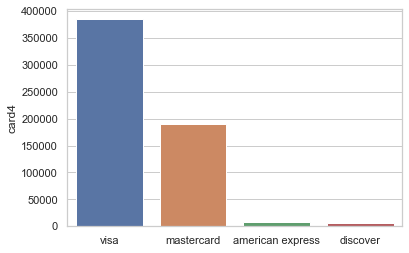

In [29]:
print(train.card4.value_counts())

sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x = train.card4.value_counts().index, y = train.card4.value_counts(), data=train)

#### P_ and (R__) emaildomain

In [30]:
train.iloc[:,15:17]

,P_emaildomain,R_emaildomain
0,NaN,NaN
1,gmail.com,NaN
2,outlook.com,NaN
3,yahoo.com,NaN
4,gmail.com,NaN
...,...,...
590535,NaN,NaN
590536,gmail.com,NaN
590537,gmail.com,NaN
590538,aol.com,NaN


In [31]:
train.iloc[:,15:17].isna().sum()

P_emaildomain     94456
R_emaildomain    453249
dtype: int64

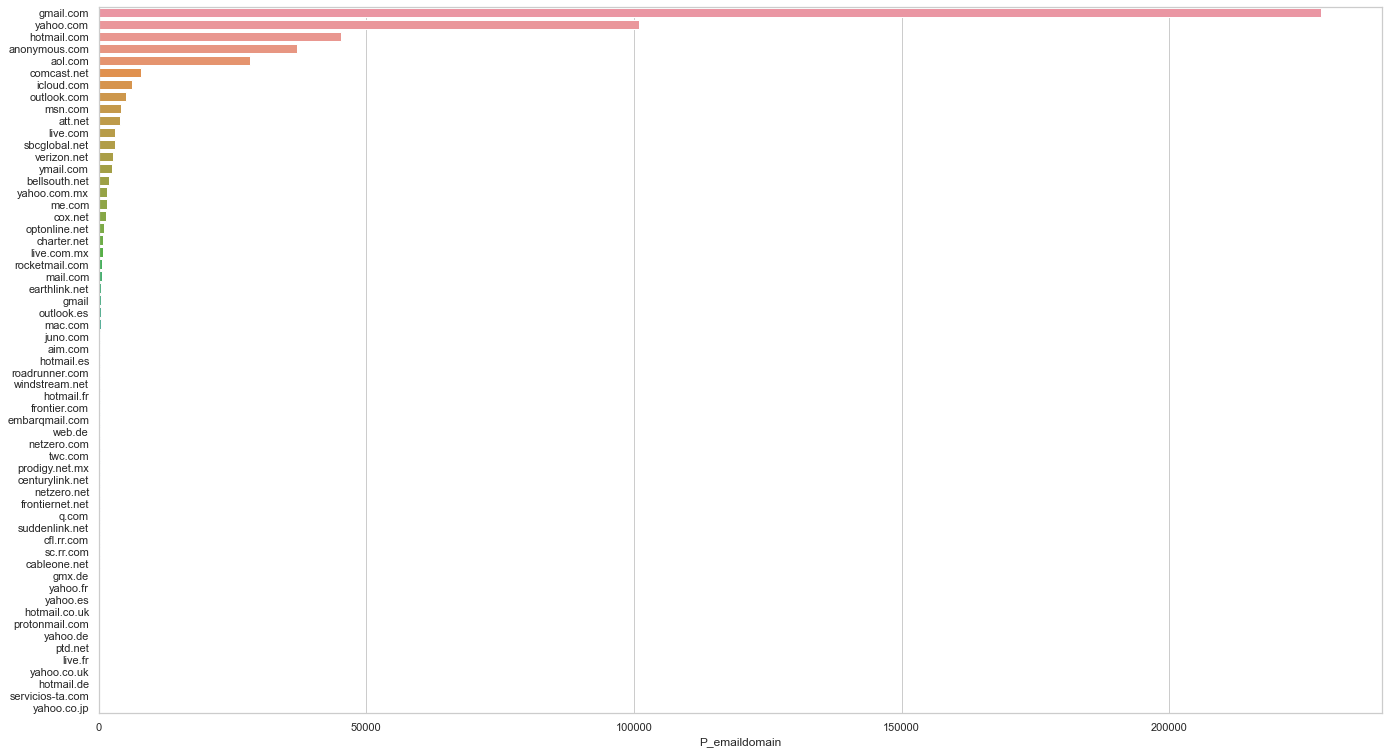

In [48]:
# print(train.P_emaildomain.value_counts())

plt.figure(figsize=(23,13))
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x = train.P_emaildomain.value_counts(), y = train.P_emaildomain.value_counts().index, data=train, orient='h')

#### V

In [33]:
v_cols = [v for v in train if v[0] == 'V']
train[v_cols]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
train[v_cols].describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
mean,0.999945,1.045204,1.078075,0.846456,0.876991,1.045686,1.072870,1.027704,1.041529,0.463915,...,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,0.007390,0.240133,0.320890,0.440053,0.475902,0.239385,0.304779,0.186069,0.226339,0.521522,...,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,25.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,1.000000,8.000000,9.000000,6.000000,6.000000,9.000000,9.000000,8.000000,8.000000,4.000000,...,55.000000,160000.000000,160000.000000,160000.000000,55125.000000,55125.00000,55125.000000,104060.000000,104060.000000,104060.000000


In [35]:
V_count = round(train.iloc[:,55:394].isna().sum()/len(train),4)
for v, i in zip(V_count.index, V_count):
    print(v,i)

V1 0.4729
V2 0.4729
V3 0.4729
V4 0.4729
V5 0.4729
V6 0.4729
V7 0.4729
V8 0.4729
V9 0.4729
V10 0.4729
V11 0.4729
V12 0.1288
V13 0.1288
V14 0.1288
V15 0.1288
V16 0.1288
V17 0.1288
V18 0.1288
V19 0.1288
V20 0.1288
V21 0.1288
V22 0.1288
V23 0.1288
V24 0.1288
V25 0.1288
V26 0.1288
V27 0.1288
V28 0.1288
V29 0.1288
V30 0.1288
V31 0.1288
V32 0.1288
V33 0.1288
V34 0.1288
V35 0.2861
V36 0.2861
V37 0.2861
V38 0.2861
V39 0.2861
V40 0.2861
V41 0.2861
V42 0.2861
V43 0.2861
V44 0.2861
V45 0.2861
V46 0.2861
V47 0.2861
V48 0.2861
V49 0.2861
V50 0.2861
V51 0.2861
V52 0.2861
V53 0.1306
V54 0.1306
V55 0.1306
V56 0.1306
V57 0.1306
V58 0.1306
V59 0.1306
V60 0.1306
V61 0.1306
V62 0.1306
V63 0.1306
V64 0.1306
V65 0.1306
V66 0.1306
V67 0.1306
V68 0.1306
V69 0.1306
V70 0.1306
V71 0.1306
V72 0.1306
V73 0.1306
V74 0.1306
V75 0.151
V76 0.151
V77 0.151
V78 0.151
V79 0.151
V80 0.151
V81 0.151
V82 0.151
V83 0.151
V84 0.151
V85 0.151
V86 0.151
V87 0.151
V88 0.151
V89 0.151
V90 0.151
V91 0.151
V92 0.151
V93 0.151
V94 0

In [36]:
# train[v_cols].corr()

 ----
 ----

In [37]:
# 메모리확보 위해 필요없는 변수 제거
del total_missing

### 'TransactionID'에 대해 유니크한 속성 개수 & 비율

In [38]:
# print(np.sum(train['TransactionID'].isin(train_id['TransactionID'].unique())))
# print(np.sum(test_transaction['TransactionID'].isin(test_id['TransactionID'].unique())))
print()
print(round(144233 / 590540 *100, 1), "% => 144233 / 590540 --TransactionIDs in train, have an associated train_identity")
print(round(141907 / 506692 *100, 1), "% => 141907 / 506692 --TransactionIDs in test, have an associated test_identity")


24.4 % => 144233 / 590540 --TransactionIDs in train, have an associated train_identity
28.0 % => 141907 / 506692 --TransactionIDs in test, have an associated test_identity


[데이터 확인 결과] NaN 과 마스킹 처리되어 어떤 정보인지 알 수 없는 column들이 많음 -> 전처리 진행 <br>
    - train_transaction : ``C1, C2 ... D1, V300, V339 ...``<br>
    - train_id : ``id_01 ... id_38``